In [1]:
%load_ext autotime
%load_ext tensorboard

time: 17.1 ms (started: 2023-01-15 18:20:43 +08:00)


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
import tensorflow as tf
import numpy as np
import lzma
import pickle, joblib
from string import ascii_lowercase
from numba import cuda
import sklearn.utils
import random
from collections import defaultdict
from operator import itemgetter
import gc
import datetime, os
import matplotlib.pyplot as plt
from tensorboard import notebook
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

2023-01-15 18:20:44.616176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 18:20:53.905302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-15 18:20:53.905447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cud

time: 17.8 s (started: 2023-01-15 18:20:44 +08:00)


In [3]:
BATCH_SIZE = 16
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs
time: 249 ms (started: 2023-01-15 18:21:09 +08:00)


2023-01-15 18:21:09.169145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 18:21:09.314683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31152 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0


In [13]:
class LaserDataset:
    def __init__(self, x, y, batch_size=32):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.indexes = sklearn.utils.shuffle(range(x.shape[0]))
        self.step_per_epoch = (len(y) - 1) // batch_size + 1

    @staticmethod
    def chunks(data, batch_size=32):
        for _i in range(0, len(data), batch_size):
            yield data[_i: _i + batch_size]

    @staticmethod
    def get_ind_x(data, indices):
        with tf.device("/cpu:0"):
            data = [data[_ind] for _ind in indices]  # (bsize, None, H, W, 1)
            len_map = list(map(len, data))
            data = [im for d in data for im in d]
            return tf.RaggedTensor.from_row_lengths(data, row_lengths=len_map)
    
    @staticmethod
    def get_ind_y(data, indices):
        return np.array(itemgetter(*indices)(data))

    def __iter__(self):
        with tf.device("/gpu:0"):
            while True:
                for ind in self.chunks(self.indexes, batch_size=self.batch_size):
                    yield self.get_ind_x(self.x, ind), self.get_ind_y(self.y, ind)

time: 1.04 ms (started: 2023-01-15 18:25:05 +08:00)


In [14]:
def under_sample(inputs, labels, cap_val=60, shuffle=True):
    with tf.device("/cpu:0"):
        counter = defaultdict(int)
        indexes = sklearn.utils.shuffle(range(inputs.shape[0])) if shuffle else range(len(inputs))
        out_input = []
        out_label = []
        for ind in indexes:
            la = np.where(labels[ind] == 1)[0][0]
            counter[la] += 1
            if counter[la] <= cap_val:
                out_input.append(inputs[ind])
                out_label.append(labels[ind])
        del inputs, labels
        len_map = list(map(len, out_input))
        out_input = [im for d in out_input for im in d]
        return tf.RaggedTensor.from_row_lengths(
                    out_input,
                    row_lengths=len_map
                ), np.array(out_label)

time: 1.21 ms (started: 2023-01-15 18:25:06 +08:00)


In [15]:
def split_data(x, y, validation_split=0.2):
    with tf.device("/cpu:0"):
        dlen = int(x.shape[0] * (1 - validation_split))
        return (x[:dlen], y[:dlen]), (x[dlen:], y[dlen:])

time: 1 ms (started: 2023-01-15 18:25:06 +08:00)


In [16]:
"""
X = []
Y = []

for i, c in enumerate(list(ascii_lowercase) + ["no_label"]):
    print(f"loading [{i}]...", end="\r")
    with lzma.open(f"lzma_compressed/{c}.p.xz") as f:
        now = pickle.load(f)
        for _ in range(len(now)):
            Y.append(np.array([0 if _i != i else 1 for _i in range(27)]))
"""
print("loading data")
with tf.device("/cpu:0"):
    with open("data_lz4_Y_NP.p", "rb") as f:
        Y = joblib.load(f)[..., tf.newaxis]

    with open("data_lz4_RT_TF.p", "rb") as f:
        X = joblib.load(f)[..., tf.newaxis]

print("data loading done.\nnow normalizing")
Y = np.array(Y, dtype=np.float32)
print("done")

loading data
data loading done.
now normalizing
done
time: 32.3 s (started: 2023-01-15 18:25:07 +08:00)


In [ ]:
print("under sampling")
X, Y = under_sample(X, Y)
gc.collect()

print("under sampling done, splitting data")
(x_train, y_train), (x_test, y_test) = split_data(X, Y)
del X, Y
test_data = LaserDataset(x_test, y_test, batch_size=BATCH_SIZE)
del x_test, y_test

(x_train, y_train), (x_val, y_val) = split_data(x_train, y_train)
val_data = LaserDataset(x_val, y_val, batch_size=BATCH_SIZE)
del x_val, y_val

train_data = LaserDataset(x_train, y_train, batch_size=BATCH_SIZE)
del x_train, y_train
print("all done")

under sampling


In [9]:
"""
drop_rate = 0.0
cnn2 = keras.models.Sequential([
        layers.Conv2D(8, 3, padding="same", activation=layers.LeakyReLU()),
        layers.MaxPooling2D(3),
        layers.BatchNormalization(),
        layers.Dropout(drop_rate),
        layers.Conv2D(16, 3, padding="same", activation=layers.LeakyReLU()),
        layers.MaxPooling2D(3),
        layers.BatchNormalization(),
        layers.Dropout(drop_rate),
        layers.Conv2D(32, 3, padding="same", activation=layers.LeakyReLU()),
        layers.MaxPooling2D(3),
        layers.BatchNormalization(),
        layers.Dropout(drop_rate),
        layers.Conv2D(64, 3, padding="same", activation=layers.LeakyReLU()),
        layers.MaxPooling2D(3),
        layers.BatchNormalization(),
        layers.Dropout(drop_rate),
        layers.Flatten()
    ])
"""
drop_rate = 0.0
cnn2 = keras.models.Sequential([
        layers.Conv2D(8, 3, padding="same", activation=layers.LeakyReLU()),
        layers.MaxPooling2D(3),
        layers.BatchNormalization(),
        layers.Dropout(drop_rate),
        layers.Conv2D(16, 3, padding="same", activation=layers.LeakyReLU()),
        layers.MaxPooling2D(3),
        layers.BatchNormalization(),
        layers.Dropout(drop_rate),
        layers.Conv2D(32, 3, padding="same", activation=layers.LeakyReLU()),
        layers.MaxPooling2D(3),
        layers.BatchNormalization(),
        layers.Dropout(drop_rate),
        layers.Conv2D(64, 3, padding="same", activation=layers.LeakyReLU()),
        layers.MaxPooling2D(3),
        layers.BatchNormalization(),
        layers.Dropout(drop_rate),
        layers.Flatten()
    ])

time: 34.4 ms (started: 2023-01-15 18:22:20 +08:00)


In [10]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    inp = layers.Input(shape=(None, 175, 175, 1), ragged=True)
    cnn = cnn2
    x = layers.TimeDistributed(cnn)(inp)
    x = layers.LSTM(units=32, recurrent_regularizer='l1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=27, activation="softmax")(x)

    model = keras.Model(inputs=inp, outputs=x)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 175, 175,   0         
                             1)]                                 
                                                                 
 time_distributed (TimeDistr  (None, None, 256)        24864     
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 32)                36992     
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 27)                891       
                                                             

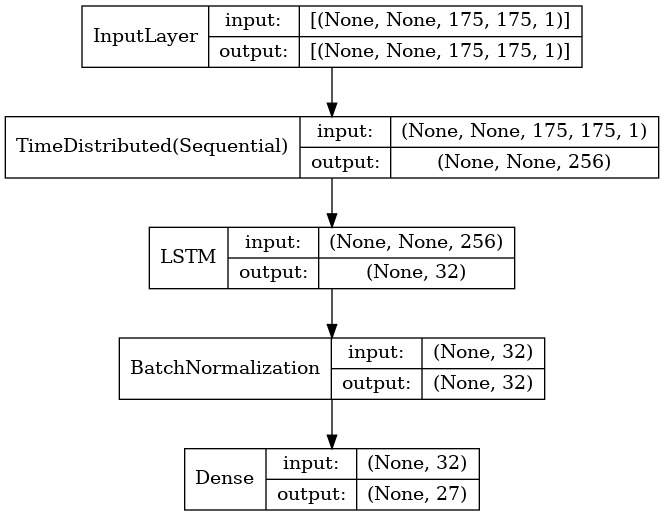

time: 621 ms (started: 2023-01-15 18:22:45 +08:00)


In [11]:
model.summary()
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

In [12]:
MODEL_NAME = "CL_250EccLrO3D_lstmreg_test"
MODEL_CKPT_PATH = f"ckpt/{MODEL_NAME}.h5"
with strategy.scope():
    make_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        MODEL_CKPT_PATH, 
        monitor="val_loss", 
        verbose=1, 
        save_best_only=True, 
        mode="min"
    )
    logdir = os.path.join("logs", f"{MODEL_NAME}_{datetime.datetime.now().strftime('%H%M')}")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), 
                  loss="categorical_crossentropy", 
                  metrics=["acc"])
    history = model.fit(x=iter(train_data),
                        validation_data=iter(val_data),
                        steps_per_epoch=train_data.step_per_epoch,
                        validation_steps=val_data.step_per_epoch,
                        epochs=250, 
                        verbose=1,
                        callbacks=[make_checkpoint_callback, tensorboard_callback])

Epoch 1/250


2023-01-15 18:23:11.380515: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}

2023-01-15 18:23:16.299794: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f06c8868240 initialized for platform CUDA (this does not

13/54 [======>.......................] - ETA: 28s - loss: 6.3230 - acc: 0.0769

2023-01-15 18:23:30.626686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 876 feature_map_count: 1 spatial: 175 175  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 8 input_feature_map_count: 1 layout: OutputInputYX shape: 3 3 }
  {zero_padding: 1 1  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-01-15 18:23:30.705917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 876 feature_map_count: 8 spatial: 58 58  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 16 input_feature_map_count: 8 layout: OutputInputYX shape: 3 3 }
  {zero_padding: 1 1  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity a

16/54 [=======>......................] - ETA: 27s - loss: 6.2780 - acc: 0.0898

2023-01-15 18:23:33.207768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 944 feature_map_count: 1 spatial: 175 175  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 8 input_feature_map_count: 1 layout: OutputInputYX shape: 3 3 }
  {zero_padding: 1 1  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-01-15 18:23:33.291838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 944 feature_map_count: 8 spatial: 58 58  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 16 input_feature_map_count: 8 layout: OutputInputYX shape: 3 3 }
  {zero_padding: 1 1  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity a

33/54 [=================>............] - ETA: 15s - loss: 6.0845 - acc: 0.1042

2023-01-15 18:23:45.403537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 965 feature_map_count: 1 spatial: 175 175  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 8 input_feature_map_count: 1 layout: OutputInputYX shape: 3 3 }
  {zero_padding: 1 1  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-01-15 18:23:45.490103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 965 feature_map_count: 8 spatial: 58 58  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 16 input_feature_map_count: 8 layout: OutputInputYX shape: 3 3 }
  {zero_padding: 1 1  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity a

45/54 [========================>.....] - ETA: 6s - loss: 6.0219 - acc: 0.1042

2023-01-15 18:23:53.527408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 907 feature_map_count: 1 spatial: 175 175  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 8 input_feature_map_count: 1 layout: OutputInputYX shape: 3 3 }
  {zero_padding: 1 1  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-01-15 18:23:53.608829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 907 feature_map_count: 8 spatial: 58 58  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 16 input_feature_map_count: 8 layout: OutputInputYX shape: 3 3 }
  {zero_padding: 1 1  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity a

54/54 [==============================] - ETA: 0s - loss: 5.9736 - acc: 0.1133

2023-01-15 18:23:59.679802: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:11"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



KeyboardInterrupt: 

time: 51 s (started: 2023-01-15 18:23:11 +08:00)


In [23]:
model.save(f"models/{MODEL_NAME}.h5")

time: 57.7 ms (started: 2023-01-12 09:31:04 +08:00)


In [16]:
model.load_weights(f"models/CL_800EccLrO3D_lstmreg.h5")

In [24]:
model.evaluate(test_data.x, test_data.y[:, :, 0])

2023-01-12 09:31:48.324167: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_VARIANT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 268
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:2555"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 27
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
  

9/9 [==============================] - 13s 723ms/step - loss: 1.1579 - acc: 0.7575


[1.1578991413116455, 0.7574626803398132]

time: 13.1 s (started: 2023-01-12 09:31:47 +08:00)


In [ ]:
model.evaluate_generator(generator=iter(test_data),
                         steps=test_data.step_per_epoch,
                         verbose=0)

In [15]:
with open("test.p", "wb+")as f:
    joblib.dump(X, f, compress='lz4')

time: 49.6 s (started: 2023-01-08 15:38:01 +08:00)


In [6]:
with open("data_lz4_Y_NP.p", "wb+") as f:
    joblib.dump(Y, f, compress="lz4")

time: 3.36 ms (started: 2023-01-09 11:37:19 +08:00)


In [ ]:
# print(type(X))
# X = tf.RaggedTensor.from_row_lengths(values=tmp, row_lengths=list(map(len, X)), validate=False)

In [42]:
device = cuda.get_current_device()
device.reset()

time: 4.29 s (started: 2023-01-08 15:24:31 +08:00)


In [11]:
for i, j in train_data:
    print(tf.reduce_min(i), tf.reduce_min(j))

tf.Tensor(0.12941177, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.12941177, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.12941177, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.11764706, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.12156863, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.13333334, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.1254902, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


KeyboardInterrupt: 

time: 3.7 s (started: 2023-01-10 16:21:29 +08:00)


In [8]:
print(X.shape)

(2583, None, 175, 175)
time: 1.12 ms (started: 2023-01-08 15:56:43 +08:00)


In [9]:
X = X[..., tf.newaxis]

time: 4.21 ms (started: 2023-01-08 15:56:48 +08:00)


In [9]:
tf.reduce_min(X)

NameError: name 'X' is not defined

time: 112 ms (started: 2023-01-10 12:31:19 +08:00)


In [21]:
print(test_data.x.shape, test_data.y.shape)

(268, None, 175, 175, 1) (268, 27, 1)


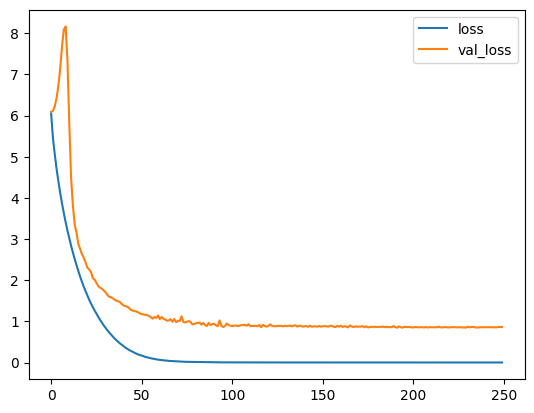

time: 98.5 ms (started: 2023-01-12 09:40:13 +08:00)


In [32]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

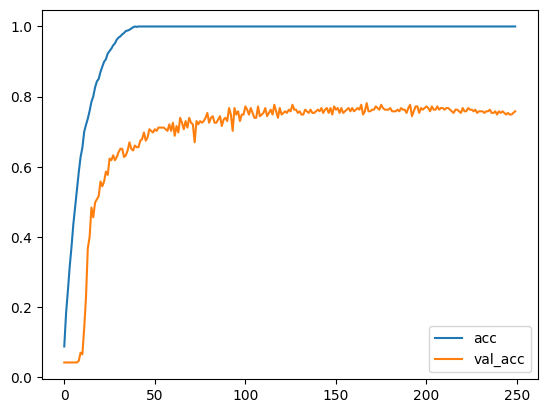

time: 93 ms (started: 2023-01-12 09:40:14 +08:00)


In [33]:
plt.plot(history.history["acc"], label="acc")
plt.plot(history.history["val_acc"], label="val_acc")
plt.legend()
plt.show()

predicting test data


2023-01-12 09:39:13.930208: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_VARIANT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 268
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:2659"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_LEGACY_VARIANT
        }
      }
    }
  }
}



9/9 [==============================] - 5s 106ms/step
making confussion matrix


<AxesSubplot:>

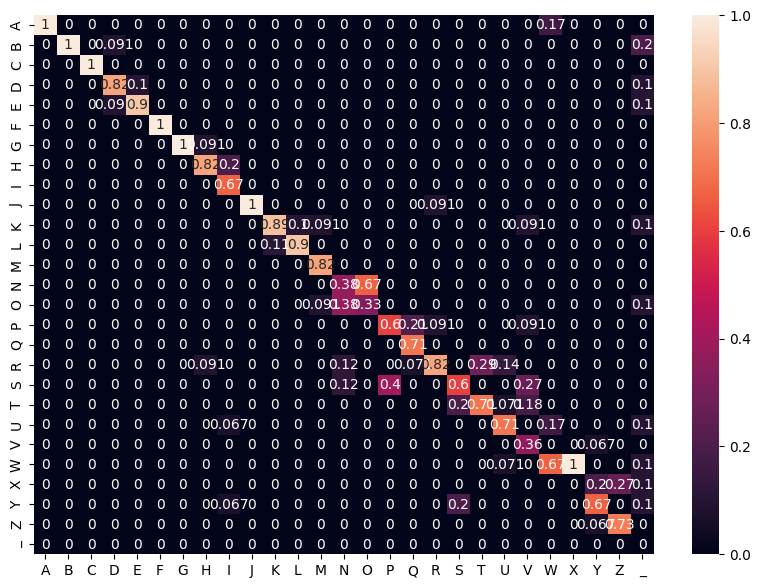

time: 7.05 s (started: 2023-01-12 09:39:13 +08:00)


In [31]:
print("predicting test data")
y_prediction = model.predict(test_data.x)
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(test_data.y, axis=1)
print("making confussion matrix")
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

df_cm = pd.DataFrame(result, index=[i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ_"],
                     columns=[i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ_"])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True)